# Multivariate regression simple prior with estimated scalar

Here I use multivariate prior (not mash mixture) for `msusie` call, but allow for the scalar of prior to be estimated. That is, I have implemeted `estimate_prior_variance` for [this class](https://github.com/gaow/mmbr/blob/1c9b14283aa9615436447738932618c81388bd41/R/bayesian_multivariate_regression.R#L7).

In [1]:
library(mmbr)
set.seed(2)

Loading required package: mashr
Loading required package: ashr


In [2]:
dat = mmbr_sim1(r=5,s=1)

In [3]:
dim(dat$X)

[1] 200 500

In [4]:
dim(dat$y)

[1] 200   5

In [5]:
true_pos = as.integer(apply(dat$b, 1, sum) != 0)
sum(true_pos)

[1] 5

As you can see in this simulated data-set there are 5 true effects. Now I set $L=10$. Here the prior used is not oracle prior but just 0.2 times covariance of $Y$.

In [6]:
L=10

## Not estimating prior variance scalar 

In [7]:
start = Sys.time()
res = mmbr::msusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=F)
Sys.time() - start

Time difference of 4.728001 secs

In [8]:
res$elbo

[1] -1659.178 -1630.437 -1630.375 -1630.372 -1630.372

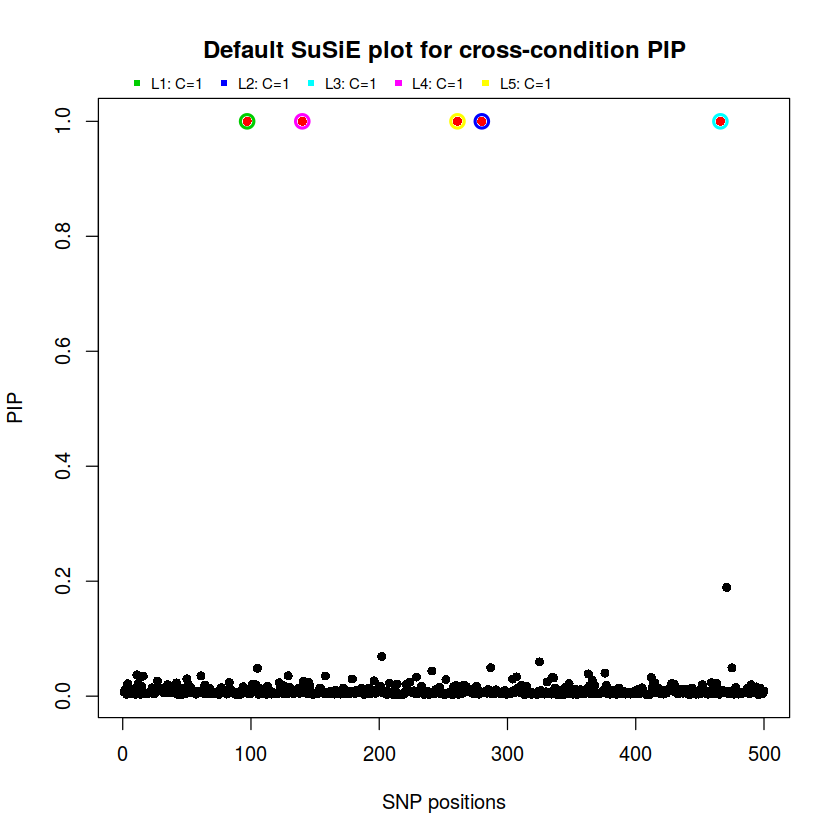

In [9]:
susieR::susie_plot(res,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

## Estimating prior variance scalar

In [10]:
start = Sys.time()
res2 = mmbr::msusie(dat$X,dat$y,L=L,prior_variance=dat$V,compute_objective=T,estimate_residual_variance=F,estimate_prior_variance=T)
Sys.time() - start

Time difference of 6.550407 mins

In [11]:
res2$elbo

[1] -1617.629 -1589.345 -1589.322 -1589.322

The ELBO is indeed better, but it takes much longer time -- per iteration time is over **100 times** compared to when the scalar is not estimated. 

The estimated scalars for prior variance are:

In [12]:
res2$V

[1] 5.803480e-01 5.324826e-01 4.488470e-01 5.534361e-01 4.357475e-01
 [6] 0.000000e+00 3.754822e-10 1.295399e-10 3.739381e-10 3.147297e-10

As expected only the first 5 effects are non-zero.

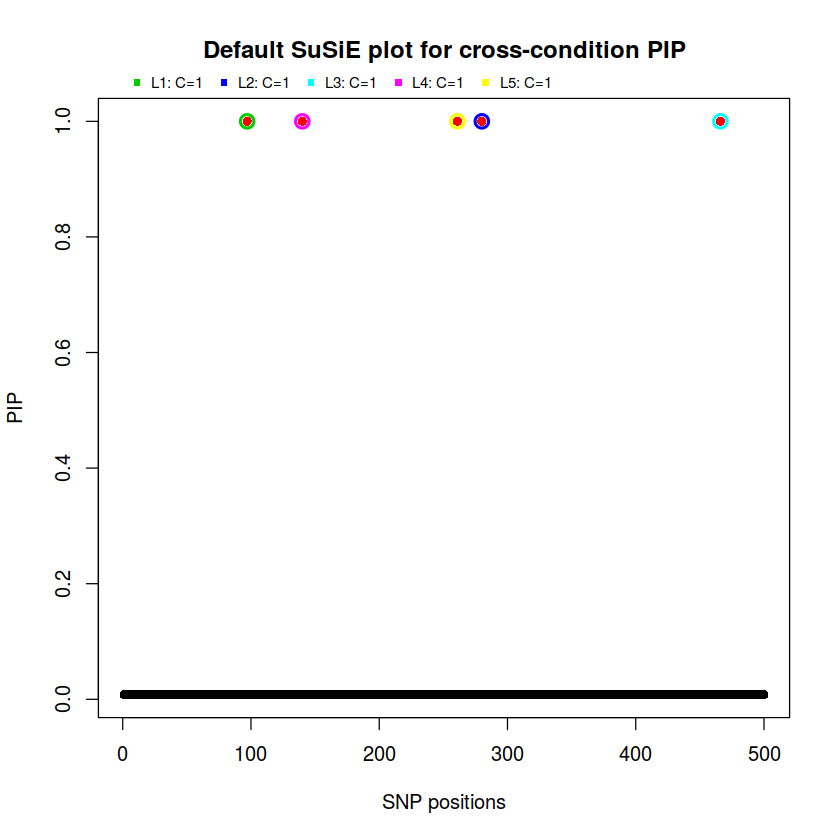

In [13]:
susieR::susie_plot(res2,y='PIP', main = 'Default SuSiE plot for cross-condition PIP', xlab = 'SNP positions', add_legend = T, b=true_pos)

The PIP plot also appears a lot cleaner.